## 1. 标准线性回归(LR)
$$\mathbf{y} = \mathbf{X}w + b$$
$$平方误差：\sum_{i=1}^m (y_i - x_i^Tw)^2$$
$$导数为零求得：\hat{w} = (\mathbf{X}^T\mathbf{X})^{-1}\mathbf{X}^Ty$$
目标：__最小平方误差__。  
注意，需要先判断矩阵是否可逆，判断方法：行列式不为零。

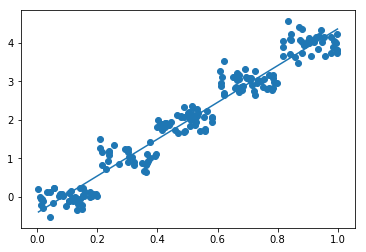

In [4]:
from numpy import *
import matplotlib.pyplot as plt

#读取数据
def loadDataSet(filename):
    numFeat = len(open(filename).readline().split('\t'))-1
    dataMat = []; labelMat = []
    fr = open(filename)
    for line in fr.readlines():
        lineArr = []
        curLine = line.strip().split('\t')
        for i in range(numFeat):
            lineArr.append(float(curLine[i]))
        dataMat.append(lineArr)
        labelMat.append(float(curLine[-1]))
    return dataMat, labelMat

#标准线性回归函数
def standRegres(xArr, yArr):
    xMat = mat(xArr)
    yMat = mat(yArr).T
    xTx = xMat.T * xMat
    #判断行列式为零，则无法求逆
    if linalg.det(xTx) == 0:
        print('the matrix is singular, cannot do inverse')
        return
    ws = (xTx).I * (xMat.T*yMat)
    return ws

#拟合数据
xArr, yArr = loadDataSet('ex0.txt')
ws = standRegres(xArr, yArr)
xMat = mat(xArr)
yMat = mat(yArr)
yHat = xMat*ws
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xMat[:,1].flatten().A[0], yMat.T[:,0].flatten().A[0])
xCopy = xMat.copy()
xCopy.sort(0)
yHat = xCopy*ws
ax.plot(xCopy[:,1], yHat)
plt.show()

计算$\hat{y}$ 和 $y$ 之间的相关系数，用来判断预测值和实际值的匹配程度。

In [6]:
yHat = xMat*ws
corrcoef(yHat.T, yMat)

array([[1.        , 0.97223133],
       [0.97223133, 1.        ]])

## 2. 局部加权线性回归(LWLR)
标准线性回归依据最小均方误差（MSE），则可能会导致欠拟合。因此可以在估计中加入偏差，降低预测的均方误差。  
__局部加权线性回归__:给待遇测点附近每个点赋予一定的权重，然后继续进行最小均方差回归。设置一个权重矩阵$W$,给每个数据点赋予一个权重。可以使用__核__来给附近的点赋予更大的权值，常用的是高斯核：  
$$ w(i,i) = exp(\frac{|x^(i) - x|}{-2k^2})$$  
权重$\mathbf{W}$只含有对角元素，点x与x(i)越近，上述权重越大，k为一个用户自定义的参数。  
随后计算线性模型的权重$\hat{w}$:  
$$ \hat{w} = (\mathbf{X^T}\mathbf{W}\mathbf{X})^{-1}\mathbf{X}^T\mathbf{W}y $$


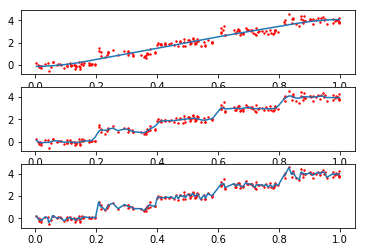

In [10]:
def lwlr(testPoint,xArr, yArr, k = 1.0):
    xMat = mat(xArr)
    yMat = mat(yArr).T
    m = shape(xMat)[0]
    #设置权重初始对角矩阵，为每一个样本点初始化了权重值为1
    weights = mat(eye(m))
    #遍历数据集，计算每个样本点对应权值
    for j in range(m):
        #样本点与待遇测点之间的距离
        diffMat = testPoint - xMat[j,:]
        #计算对应权值
        weights[j,j] = exp(diffMat*diffMat.T/(-2.0*k**2))
    xTx = xMat.T*(weights*xMat)
    #判断是否可逆
    if linalg.det(xTx) == 0:
        print('cannot inverse')
        return
    ws = xTx.I*(xMat.T*(weights*yMat))
    return testPoint*ws

#测试函数
def lwlrTest(testArr, xArr, yArr, k = 1.0):
    m = shape(testArr)[0]
    yHat = zeros(m)
    #依次预测测试数据的yHat的值
    for i in range(m):
        yHat[i] = lwlr(testArr[i], xArr, yArr, k)
    return yHat

#测试一下
xArr, yArr = loadDataSet('ex0.txt')
#得到所有点的估计
yHat0 = lwlrTest(xArr, xArr, yArr, 0.1)
yHat1 = lwlrTest(xArr, xArr, yArr, 0.01)
yHat = lwlrTest(xArr, xArr, yArr, 0.003)
#绘制图像
xMat = mat(xArr)
srtInd = xMat[:,1].argsort(0)
xSort = xMat[srtInd][:,0,:]
fig = plt.figure()

ax = fig.add_subplot(311)
ax.plot(xSort[:,1], yHat0[srtInd])
ax.scatter(xMat[:,1].flatten().A[0], mat(yArr).T.flatten().A[0], s = 2, c = 'red')

ax = fig.add_subplot(312)
ax.plot(xSort[:,1], yHat1[srtInd])
ax.scatter(xMat[:,1].flatten().A[0], mat(yArr).T.flatten().A[0], s = 2, c = 'red')

ax = fig.add_subplot(313)
ax.plot(xSort[:,1], yHat[srtInd])
ax.scatter(xMat[:,1].flatten().A[0], mat(yArr).T.flatten().A[0], s = 2, c = 'red')
plt.show()
    

以上自下：k=0.1， k= 0.01, k = 0.003.  
由上图知，局部加权线性回归可以更好的拟合数据。且k值越小（越精细），拟合程度越好。但是k值过小会导致过拟合。 

In [13]:
#预测鲍鱼年龄

#计算平方误差
def ressError(yArr, yHatArr):
    return ((yArr-yHatArr)**2).sum()

#不同的核大小对应的误差
abX, abY = loadDataSet('abalone.txt')
yHat01 = lwlrTest(abX[0:99], abX[0:99], abY[0:99], 0.1)
yHat1 = lwlrTest(abX[0:99], abX[0:99], abY[0:99], 1)
yHat10 = lwlrTest(abX[0:99], abX[0:99], abY[0:99], 10)
print('k=0.1, error:', ressError(abY[0:99],yHat01.T))
print('k=1, error:', ressError(abY[0:99],yHat1.T))
print('k=10, error:', ressError(abY[0:99],yHat10.T))

k=0.1, error: 56.78868743050092
k=1, error: 429.89056187038
k=10, error: 549.1181708827924


由上述结果显示，核越小，误差越小。但是核太小可能会导致__过拟合__，对新数据的效果差。   
假设我们使用数据集的前100个数据作为拟合点来拟合数据集的后100个数据。

In [17]:
yHat01 = lwlrTest(abX[100:199], abX[0:99], abY[0:99], 0.1)
yHat1 = lwlrTest(abX[100:199], abX[0:99], abY[0:99], 1)
yHat10 = lwlrTest(abX[100:199], abX[0:99], abY[0:99], 10)
print('k=0.1, error:', ressError(abY[100:199],yHat01.T))
print('k=1, error:', ressError(abY[100:199],yHat1.T))
print('k=10, error:', ressError(abY[100:199],yHat10.T))
ws = standRegres(abX[0:99], abY[0:99])
yHat = mat(abX[100:199])*ws
print('standard LR error:', ressError(abY[100:199], yHat.T.A))

k=0.1, error: 57913.51550155911
k=1, error: 573.5261441895982
k=10, error: 517.5711905381903
standard LR error: 518.6363153245542


由上述结果显示，对于新数据，k=10的拟合效果较好，反而k=0.1的误差最大，也就是产生了过拟合。而且标准线性回归的效果也不比lwlr差。

## 3.缩减系数
缩减回归系数，也就是起到特征选择的作用。大致有两种方法，岭回归主要针对特征维度大于样本数的情况，而前向逐步回归则是一种贪心算法，通过对某特征增加或减小来判断该特征的变化是否会导致整个模型的误差的变化，因此可以起到特征选择的作用。这两种方法一般用于__回归__任务中。
### 3.1 岭回归
当数据的特征维度太大，大于数据个数时，由于$\mathbf{X}^T\mathbf{X}$ 无法求逆，导致无法使用线性回归。因此需要__系数缩减__方法来__降低特征维度__。岭回归一般用于处理__特征数多于样本数__的情况。在$\mathbf{X}^T\mathbf{X}$ 后加一项 $\lambda\mathbf{I}$ 使矩阵可变成 $\mathbf{X}^T\mathbf{X}+\lambda\mathbf{I}$, 该项可逆。回归系数公式为：  
$$\hat{w} = (\mathbf{X}^T\mathbf{X}+\lambda\mathbf{I})^{-1}\mathbf{X}^Ty$$   
__主要思想__: 加一项对角矩阵使原不可逆矩阵可逆。计算出不同组回归系数，选取在测试集上误差最小的。同时对于每一个特征，其对应的系数越大，说明该特征越应该保留，系数越小越应该放弃该特征。

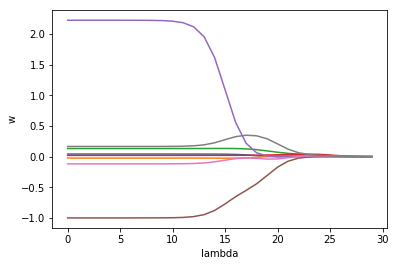

In [22]:
#岭回归主函数
def ridgeRegres(xMat, yMat,lam=0.2):
    xTx = xMat.T*xMat
    #加一项对角矩阵，使整体可逆
    denom = xTx + eye(shape(xMat)[1])*lam
    #仍然需要判断是否可逆，因为当lam=0时，可能不可逆
    if linalg.det(denom) == 0:
        print('cannot inverse')
        return 
    ws = denom.I*(xMat.T*yMat)
    return ws

#岭回归测试函数
def ridgeTest(xArr,yArr):
    xMat = mat(xArr)
    yMat=mat(yArr).T
    yMean = mean(yMat,0)
    #数据标准化
    yMat = yMat - yMean     
    xMeans = mean(xMat,0)   
    xVar = var(xMat,0)
    #减均值除以方差
    xMat = (xMat - xMeans)/xVar
    #使用30个不同的lam值进行测试
    numTestPts = 30
    wMat = zeros((numTestPts,shape(xMat)[1]))
    for i in range(numTestPts):
        ws = ridgeRegres(xMat,yMat,exp(i-10))
        wMat[i,:]=ws.T
    return wMat

#进行测试
abX,abY = loadDataSet('abalone.txt')
ridgeweights = ridgeTest(abX, abY)
#查看缩减效果
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ridgeweights)
plt.xlabel('lambda')# make axis labels
plt.ylabel('w')
plt.show()

由上图可知，随着lamda的取值不同，回归系数w也在变化。lambda极小时，回归系数和标准线性回归一样，当lambda极大时，所有的回归系数都趋于0.最佳的lambda趋于之间。为了获得最佳lambda，一般会进行__交叉验证__。  
### 3.2 前向逐步回归
基于贪心的回归系数缩减方法。  
__主要思想__：对每一个特征增大或减小，观察对误差的影响。最后的结果是部分特征不论增大还是减小都对误差影响不大，则可以省去。

In [26]:
#数据标准化函数
def regularize(xMat):
    inMat = xMat.copy()
    inMeans = mean(inMat,0)   
    inVar = var(inMat,0)
    #减均值除以方差
    inMat = (inMat - inMeans)/inVar
    return inMat

def stageWise(xArr,yArr,eps=0.01,numIt=100):
    xMat = mat(xArr); yMat=mat(yArr).T
    #数据标准化
    yMean = mean(yMat,0)
    yMat = yMat - yMean     
    xMat = regularize(xMat)
    m,n=shape(xMat)
    #用以记录所有迭代中产生的回归系数，用作分析
    returnMat = zeros((numIt,n))
    ws = zeros((n,1)); wsTest = ws.copy(); wsMax = ws.copy()
    #迭代numIt次
    for i in range(numIt):
        if i > 190:
            print (ws.T)
        lowestError = inf; 
        #对每个特征
        for j in range(n):
            #增加（1），或减小（-1）该特征的值，eps指的是特征变化的步长。
            for sign in [-1,1]:
                wsTest = ws.copy()
                wsTest[j] += eps*sign
                yTest = xMat*wsTest
                rssE = ressError(yMat.A,yTest.A)
                #若改变该特征值后误差降低，则更新该特征值。
                if rssE < lowestError:
                    lowestError = rssE
                    wsMax = wsTest
        ws = wsMax.copy()
        returnMat[i,:]=ws.T
    return returnMat

#测试上述代码
xArr, yArr = loadDataSet('abalone.txt')
print('回归系数更新过程：')
returnMat = stageWise(xArr, yArr, 0.01, 200)

回归系数更新过程：
[[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
[[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
[[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
[[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
[[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
[[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
[[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
[[ 0.05  0.    0.09  0.03  0.31 -0.64  0.    0.36]]
[[ 0.04  0.    0.09  0.03  0.31 -0.64  0.    0.36]]


上面打印了后10轮每轮回归系数更新的结果，可以看出__第一个__和__第六个__特征系数都为0，说明这两个特征对整体的回归任务不影响，可以省去。

## 4.权衡方差和偏差
__方差__：数据扰动对模型造成的影响，也指模型对不同数据的适应能力。模型越简单，方差越小，因为不论在已知还是未知数据集上表现都不会特别好。  
__偏差__：模型拟合训练数据的能力。模型越复杂，偏差越小，在训练集上表现越好，未知测试集上可能越差（无法适应未知数据集）。   
方差度量方法：取两组数据分别拟合回归模型，得到的两组回归系数之间的差异即表示了方差的大小。   
参考：https://blog.csdn.net/simple_the_best/article/details/71167786   
> 偏差-方差窘境 (bias-variance dilemma).   
给定一个学习任务, 在训练初期, 由于训练不足, 学习器的拟合能力不够强, 偏差比较大, 也是由于拟合能力不强, 数据集的扰动也无法使学习器产生显著变化, 也就是欠拟合的情况;    
随着训练程度的加深, 学习器的拟合能力逐渐增强, 训练数据的扰动也能够渐渐被学习器学到;   
充分训练后, 学习器的拟合能力已非常强, 训练数据的轻微扰动都会导致学习器发生显著变化, 当训练数据自身的、非全局的特性被学习器学到了, 则将发生过拟合.
